In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

import os
import glob
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy
import re
import jamotools

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

import Levenshtein as Lev

In [2]:
n_mels = 80
fs = 16000
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

# meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
# data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'

# meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
# data_folder = "D:/korean-single-speaker-speech-dataset/kss"

data_folder = "D:/nsml-dataset/train_data/"
label_path = "D:/nsml-dataset/hackathon.labels"

data_list = glob.glob(data_folder + '*.csv')[0]

wav_paths = list()
script_paths = list()
korean_script_paths = list()

with open(data_list, 'r') as f:
    for line in f:
        # line: "aaa.wav,aaa.label"
        wav_path, script_path = line.strip().split(',')
        korean_script_path = script_path.replace('.label', '.script')
        
        wav_paths.append(os.path.join(data_folder, wav_path))
        script_paths.append(os.path.join(data_folder, script_path))
        korean_script_paths.append(os.path.join(data_folder, korean_script_path))

dataset_size = len(wav_paths)

In [3]:
def get_label(filepath, bos_id, eos_id):
    key = filepath.split('/')[-1].split('.')[0]
    script = target_dict[key]
    tokens = script.split(' ')
    result = list()
    result.append(bos_id)
    for i in range(len(tokens)):
        if len(tokens[i]) > 0:
            result.append(int(tokens[i]))
    result.append(eos_id)
    return result

In [4]:
print("wav_paths len: {}".format(len(wav_paths)))
print("script_paths len: {}".format(len(script_paths)))
print("korean_script_paths len: {}".format(len(korean_script_paths)))

print(wav_paths[0])
print(script_paths[0])
print(korean_script_paths[0])

wav_paths len: 29805
script_paths len: 29805
korean_script_paths len: 29805
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.wav
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.label
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.script


In [5]:
with open(script_paths[1]) as f:
    line = f.read()
    line = line.strip()
    result = list(map(int, line.split(' ')))

In [6]:
def load_label(label_path):
    char2index = dict() # [ch] = id
    index2char = dict() # [id] = ch
    with open(label_path, 'r', encoding='UTF-8') as f:
    # with open(label_path, 'r') as f:
        for no, line in enumerate(f):
            if line[0] == '#': 
                continue

            index, char, freq = line.strip().split('\t')
            char = char.strip()
            if len(char) == 0:
                char = ' '

            char2index[char] = int(index)
            index2char[int(index)] = char

    return char2index, index2char

In [7]:
char2index, index2char = load_label(label_path)
SOS_token = char2index['<s>']  # '<sos>' or '<s>'
EOS_token = char2index['</s>']  # '<eos>' or '</s>'
PAD_token = char2index['_']  # '-' or '_'

In [8]:
print('char2index len: {}'.format(len(char2index)))

print('index2char len: {}'.format(len(index2char)))

char2index len: 820
index2char len: 820


In [9]:
pure_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    pure_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    pure_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    pure_jamo_list.append(chr(unicode))

pure_jamo_list += [' ', '!', ',', '.', '?']

print(pure_jamo_list)

['ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ', ' ', '!', ',', '.', '?']


In [10]:
korean_script_list = list()
jamo_script_list = list()

# true_jamo_regex_not  = re.compile(u'[^, .?!\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

# valid_regex = re.compile(u'[,_ ^.?!？~<>:;/%()+A-Za-z0-9\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

count = 0

for file in tqdm(korean_script_paths):
    with open(file, 'r', encoding='utf-8') as f:
        line = f.read()
        line = line.strip()
        korean_script_list.append(line)
        jamo = list(jamotools.split_syllables(line, 'JAMO'))
        
#         print(len(jamo))
        for i, c in enumerate(jamo):
            if c not in pure_jamo_list:
                jamo[i] = '*'
        
        jamo = ''.join(jamo)
#         jamo_filtered = ''.join(true_jamo_regex.findall(jamo))
#         jamo_filtered = re.sub(true_jamo_regex_not, '*', jamo)
        jamo_script_list.append(jamo)
        
#         print(line)
#         print(jamo) 
        
#         if count == 100:
#             break
        
#         count += 1

In [11]:
def find_starting_point(coef, thres = 0.1, margin = 10):
    starting_point = 0
    for i in range(len(coef) - 1):
        if (coef[i] <= thres and coef[i+1] > thres):
            starting_point = i
            break
            
    starting_point = starting_point - margin
    
    if starting_point < 0:
        starting_point = 0
    
    return starting_point

def find_ending_point(coef, thres = 0.1, margin = 10):
    for i in range(len(coef) - 1, 0, -1):
        if (coef[i] <= thres and coef[i-1] > thres):
            ending_point = i
            break
            
    ending_point = ending_point + margin
    
    if ending_point > len(coef):
        ending_point = len(coef)

    return ending_point

In [12]:
class Threading_Batched_Preloader():
    def __init__(self, wav_path_list, ground_truth_list, script_path_list, batch_size, is_train=True):
        super(Threading_Batched_Preloader).__init__()
        self.wav_path_list = wav_path_list
        self.total_num_input = len(wav_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        
        self.shuffle_step = 4
        
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue(16)
        self.thread_flags = list()
        self.is_train = is_train
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        
#         print("Loading Sequence Length: {}".format(loading_sequence_len))
        
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])
            
#         for i in range(thread_num):
#             print(len(load_idxs_list[i]))

        self.end_flag = False
        
        self.queue = queue.Queue(32)
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.wav_path_list, self.ground_truth_list, self.script_path_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i, self.is_train) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()
        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False
        
        if (self.queue.empty):
            self.end_flag = True
            return True

        return False

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]
                batched_lev_truth = batch[4]
                batched_lev_truth_loss_mask = batch[5]
                
                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, batched_lev_truth, batched_lev_truth_loss_mask

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, wav_path_list, ground_truth_list, script_path_list, load_idxs_list, queue, batch_size, thread_flags, id, is_train=True):
        
        threading.Thread.__init__(self)
        self.wav_path_list = wav_path_list
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags
        self.is_train = is_train

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            success = False
            while success == False:
                try:
                    self.queue.put(batch, True)
                    success = True
                except:
                    print("Batching Failed in Thread ID: {}".format(self.id))
                    sleep(1)

        self.thread_flags[self.id] = True
        
#         print("Thread {} finished".foramt(self.id))

        return 


    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        lev_truth_list = list()
        lev_truth_length_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        max_lev_truth_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
                
            script_path = self.script_path_list[self.load_idxs_list[self.cur_idx]]
            
#             print(script_path)
            
            with open(script_path) as f:
                line = f.read()
                line = line.strip()
                lev_truth = list(map(int, line.split(' ')))
                
            lev_truth_list.append(lev_truth)
            lev_truth_length_list.append(len(lev_truth))
            
            wav_path = self.wav_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.create_mel(wav_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            if (len(lev_truth) > max_lev_truth_len):
                max_lev_truth_len = len(lev_truth)
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        batched_lev_truth = torch.zeros(count, max_lev_truth_len)
        batched_lev_truth_loss_mask = torch.zeros(count, max_lev_truth_len)
        
        for order in range(count):
            
            target = tensor_list[order]
            
            if self.is_train:
                pad_random = np.random.randint(0, 5)
                # Time shift, add zeros in front of an image
                if pad_random > 0:
                    offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                    target = torch.cat((offset, target), 1)
                # Add random noise
                target = target + (torch.rand(target.shape) - 0.5) / 20
                # Value less than 0 or more than 1 is clamped to 0 and 1
                target = torch.clamp(target, min=0.0, max=1.0)
                batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            else:
                batched_tensor[order, :tensor_size_list[order], :] = target

#           batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
            batched_lev_truth[order, :lev_truth_length_list[order]] = torch.tensor(lev_truth_list[order])
            batched_lev_truth_loss_mask[order, :lev_truth_length_list[order]] = torch.ones(lev_truth_length_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, batched_lev_truth, batched_lev_truth_loss_mask]
    
    def create_mel(self, wav_path):  
        y, sr = librosa.core.load(wav_path, sr=fs) 
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        
        # Cut-off paddings
        coef = np.sum(Sxx, 0)
        Sxx = Sxx[:, find_starting_point(coef):find_ending_point(coef)]

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref        
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input
#         return torch.zeros(1, 1, 1)

In [13]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [14]:
# unicode_jamo_list = list()

# # 초성
# for unicode in range(0x1100, 0x1113):
#     unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# # 중성
# for unicode in range(0x1161, 0x1176):
#     unicode_jamo_list.append(chr(unicode))
# # 종성
# for unicode in range(0x11A8, 0x11C3):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('A'), ord('Z') + 1):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('a'), ord('z') + 1):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('0'), ord('9') + 1):
#     unicode_jamo_list.append(chr(unicode))

# unicode_jamo_list += [' ', '\\', '!', '~', '^', '<', '>', ',', '.', "'", '?', '？', '/', '%', '(', ')', ':', ';', '+',
#                       '-', '<s>', '</s>']
# unicode_jamo_list.sort()
# # '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
# unicode_jamo_list = ['_'] + unicode_jamo_list

# tokenizer = Tokenizer(unicode_jamo_list)
# jamo_tokens = tokenizer.word2num(unicode_jamo_list)

unicode_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))

unicode_jamo_list += [' ', '!', ',', '.', '?', '<s>', '</s>', '*']

unicode_jamo_list.sort()
# '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['_'] + unicode_jamo_list

tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [15]:
print(unicode_jamo_list)
print(jamo_tokens)

['_', ' ', '!', '*', ',', '.', '</s>', '<s>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


In [16]:
ground_truth_list = [(tokenizer.word2num(['<s>'] + list(jamo_script_list[i]) + ['</s>'])) for i in range(len(jamo_script_list))]

In [17]:
# 90% of the data will be used as train
split_index = int(0.9 * len(wav_paths))

wav_path_list_train = wav_paths[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]
script_path_list_train = script_paths[:split_index]

wav_path_list_eval = wav_paths[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]
script_path_list_eval = script_paths[split_index:]

In [18]:
batch_size = 32
num_thread = 3

preloader_eval = Threading_Batched_Preloader(wav_path_list_eval, ground_truth_list_eval, script_path_list_eval, batch_size, is_train=False)
preloader_train = Threading_Batched_Preloader(wav_path_list_train, ground_truth_list_train, script_path_list_train, batch_size)

In [19]:
def train(net, optimizer, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.train()
    
    batch_size = input_tensor.shape[0]

    optimizer.zero_grad()
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    loss.backward()
    optimizer.step()

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]


def evaluate(net, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.eval()
    
    batch_size = input_tensor.shape[0]
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]

def save(model, optimizer, check_point_name):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, check_point_name)

def load(model, optimizer, check_point_name):
    checkpoint = torch.load(check_point_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [20]:
# Use GPU if GPU is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        # (B, T, H)
        output_tensor, _ = self.gru(output_tensor)
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out, num_chars):
        super(CTC_Decoder, self).__init__()
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.2) 
        self.gru = nn.GRU(H, D_out, batch_first=True)
        self.fc = nn.Linear(D_out, num_chars)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):
        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor) 
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet(nn.Module):
    def __init__(self, D_in, H, D_out, num_chars, device):
        super(Mel2SeqNet, self).__init__()
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out, num_chars).to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def forward(self, input_tensor):
        batch_size = input_tensor.shape[0]
        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)
        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        return pred_tensor

In [21]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
############################################################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, int(hidden_size/2), bidirectional=True)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        return output, hidden

    def initHidden(self, batch_size):
          return torch.zeros(2, batch_size, int(self.hidden_size/2), device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, embedded, hidden, encoder_outputs):

        embedded = self.dropout(embedded)
        
        # (1, B, H) + (1, B, H) = (1, B, 2H)        
        concated_tensor = torch.cat((embedded, hidden), 2)
        
        key = self.attn(concated_tensor) # (1, B, H)
        key = key.permute(1, 2, 0) # (B, H, 1)

        attention_value = torch.bmm(encoder_outputs, key) # (B, L, 1)
        attn_weights = F.softmax(attention_value, dim=1)
        
        attn_weights = attn_weights.permute(0, 2, 1) # (B, 1, L)
        attn_applied = torch.bmm(attn_weights, encoder_outputs) # (B, 1, H)
        attn_applied = attn_applied.permute(1, 0, 2) # (1, B, H)
        
        output = torch.cat((embedded, attn_applied), 2) # (1, B, 2H)
        output = self.attn_combine(output) # (1, B, H)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden) # (1, B, H)
        output = F.log_softmax(self.out(output), dim=2) # (1, B, 74)
        
        return output.squeeze(0), hidden, attn_weights.squeeze(1)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class Seq2SeqNet(nn.Module):
    def __init__(self, hidden_size, jamo_tokens, char2index, device):
        super(Seq2SeqNet, self).__init__()
        
        self.hidden_size = hidden_size
        self.device = device
        self.jamo_tokens = jamo_tokens
        self.char2index = char2index
        
        self.embedding_layer = nn.Embedding(len(jamo_tokens), hidden_size).to(device) 
        self.embedding_layer_2 = nn.Embedding(len(char2index), hidden_size).to(device)
        self.encoder = EncoderRNN(hidden_size).to(device)
        self.decoder = AttnDecoderRNN(hidden_size,len(char2index), dropout_p=0.1).to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer_2.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def net_train(self, input_tensor, target_tensor, loss_mask, optimizer, criterion):
        
        optimizer.zero_grad()
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]

        input_tensor = input_tensor.long()
        target_tensor = target_tensor.long()
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)

        # (L, B)
        target_tensor = target_tensor.permute(1, 0)
        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output

        decoder_input_token = torch.tensor(([self.char2index['<s>']] * batch_size)).long().unsqueeze(0).to(self.device)

        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Override encoder_hidden
        decoder_hidden = encoder_hidden

        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(self.char2index)])
        
        loss = 0

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += torch.mean(criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])

#             if np.random.rand() < 0.8:        
#                 decoder_input_token = target_tensor[di].unsqueeze(0)
#             else:
            decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)

            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
          
        loss.backward()
        
        optimizer.step()
        
        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    
    def net_eval(self, input_tensor, target_tensor, loss_mask, criterion):
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]

        input_tensor = input_tensor.long()
        target_tensor = target_tensor.long()
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)

        # (L, B)
        target_tensor = target_tensor.permute(1, 0)
        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output

        decoder_input_token = torch.tensor(([self.char2index['<s>']] * batch_size)).long().unsqueeze(0).to(self.device)

        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Override encoder_hidden
        decoder_hidden = encoder_hidden

        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(self.char2index)])
        
        loss = 0

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += torch.mean(criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])

#             if np.random.rand() < 0.8:        
#                 decoder_input_token = target_tensor[di].unsqueeze(0)
#             else:
            decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)

            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
        
        return decoder_outputs, decoder_attentions, loss.item() / target_length

In [22]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem

    result = np.asarray(result)
    
    return result

In [23]:
def Decode_Lev(tensor, index2char):
    
    str_output = list()
    
    for i in range(tensor.shape[0]):
        _, lev_idxs = tensor[i, :, :].max(-1)
        lev_idxs = lev_idxs.detach().cpu().numpy()
        decoded_sentence = list()
        for idx in lev_idxs:
            decoded_sentence.append(index2char[idx])
        str_output.append(''.join(decoded_sentence))
        
    return str_output

def Decode_Lev_Truth(tensor, index2char):
    
    str_output = list()
    
    for i in range(tensor.shape[0]):
        lev_idxs = tensor[i, :]
        decoded_sentence = list()
        for idx in lev_idxs:
            decoded_sentence.append(index2char[idx])
        str_output.append(''.join(decoded_sentence))
        
    return str_output
        

def Decode_Prediction_No_Filtering(pred_tensor, tokenizer):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        decoded_list.append(sentence)
    return decoded_list

def Decode_Prediction(pred_tensor, tokenizer, char2index):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        
        not_com_jamo = re.compile(u'[^\u3130-\u3190]')
        filtered_sentence = ''.join(not_com_jamo.findall(sentence))
        filtered_sentence = filtered_sentence.replace('<s>', '')
        filtered_sentence = filtered_sentence.replace('</s>', '')
#         filtered_sentence = filtered_sentence.replace('<eos>', '')
#         final_prediction = c2i_decoding(char2index, filtered_sentence)
        
        decoded_list.append(filtered_sentence)
    return decoded_list
    

def lev_num_to_lev_string(lev_num_list, index2char):
    lev_str_list = list()
    for num_list in lev_num_list:
        
        temp = list()
        for num in num_list:
            temp.append(index2char[num])
        
        lev_str_list.append(''.join(temp))

    return lev_str_list

def char_distance(ref, hyp):
    
    ####################
    hyp = hyp[:len(ref)]
    
    ref = ref.replace(' ', '') 
    hyp = hyp.replace(' ', '') 

    dist = Lev.distance(hyp, ref)
    length = len(ref.replace(' ', ''))

    return dist, length 

def char_distance_list(ref_list, hyp_list):

    sum_dist = 0
    sum_length = 0
    
    for ref, hyp in zip(ref_list, hyp_list):
        dist, length = char_distance(ref, hyp)
        sum_dist += dist
        sum_length += length

    return sum_dist, sum_length 

In [24]:
def Decode_Jamo_Prediction_And_Batch(pred_tensor):
    decoded_idx_list = list()
    
    max_len = 0
    
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        if len(index) > max_len:
            max_len = len(index)
        decoded_idx_list.append(index)
        
    batched_lev_input = torch.zeros(len(decoded_idx_list), max_len)
    
#     print('batched_lev_input shape: {}'.format(batched_lev_input.shape))
        
    for i, index in enumerate(decoded_idx_list):
        batched_lev_input[i, :len(index)] = torch.tensor(index)
        
    return batched_lev_input
        

No CER Record
No Seq2Seq Loss Record
Loading NSML_seq2seq_both_model_256_selective_model_save_2 Loss History Error
09-25 10:46:02
Could not found model_saved/NSML_seq2seq_both_model_256_selective_model_save_2
Could not found model_saved/seq_NSML_seq2seq_both_model_256_selective_model_save_2
Count 200 | 인터넷으로 예약이 가능한가요? __ => <s>은터렛스로 예약이 가능한가요?</s> => 아일                 


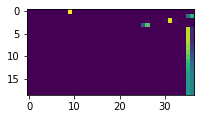

Count 400 | 잠깐만 기다려주세요 ___ => <s>잠깐만기다려주세요.</s> => 예약            


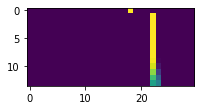

Count 600 | 구파발역에서 아웃백까지 한 번에 가는 버스가 있나요? ___ => <s>구포바녁에서 아웃백까지 한번을 가는 밫스가 있나요?</s> => 아웃 에에에에                  있       


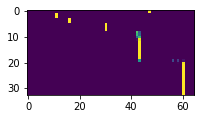

Count 800 | 아이들고 함께 먹을 메뉴 추천해주세요 ____ => <s>아이들ㄹㄹ과 함ㄴ께 막을 메뉴 추천해주세요.</s> => 위                        


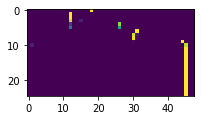

Count 808 | 오후 5시 방문 예정입니다 _ => <s>오후후 *시 바ㅜㅇ문 예정 입니다.</s> => 안          니 다 다


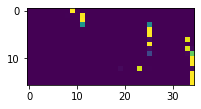

09-25 10:54:33
Mean Train Loss: 0.009428212140629654
Mean Train Seq2Seq Loss: 3.1009945470842974
Train CER: 0.9190657239563085
Eval Count 50 | 주차비가 어떻게 되는지 궁금해요 ___ => <s>추차비고 어떻게 외는지숭뭄에요?</s> => 주차      떻떻    ? ?  ? 


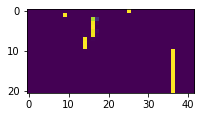

Eval Count 64 | 보통 몇시에 오픈하나요 ? __ => <s>보중 몇시에 오픈하나요?</s> => 몇시       픈하나요?   


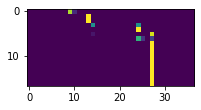

09-25 10:54:56
Mean Evaluation Loss: 0.01992021229076102
Mean Evaluation Seq2Seq Loss: 2.960426843303993
Evaluation CER: 0.8929899420908259


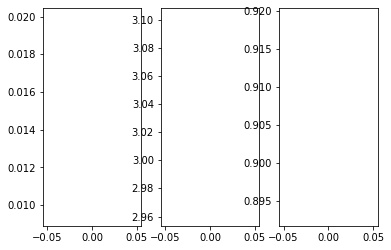

-------------------------------------------------------------------------------------------------------
09-25 10:54:56
Count 200 | 패밀리세트로 할께요 __ => <s>패미시센트ㅗ 할께요.</s> => 크밀     해요요   


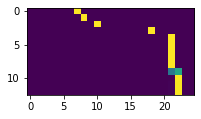

Count 400 | 현재 열명인데 룸 자리 있을까요? ___ => <s>쳔자 아명인데 롱ㅁ 살이 있을까요?</s> => 주차 인인인데      을을을요?    


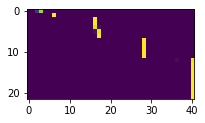

Count 600 | 스테이크 먹다가 좀 남았는데 포장해서 가져갈 수 있나요? __ => <s>제레이크 모타가소나ㅏ괐는데 갠낭하거 사여할 수 있나요?</s> => 브리이크  스   는는는는                    


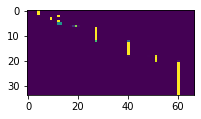

Count 800 | 각 자리마다 콘센트 있나요? _ => <s>각 차이하나 군침ㄴ티 있나요?</s> => 지장 마마       있요?? 


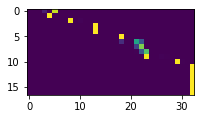

Count 808 | 영업 시간이 몇시부터 몇시까지인가요? __ => <s>영업시간이 몇시부터 몇 시까지 인가요?</s> => 영업시간  몇시부터몇몇까까지지가가?    


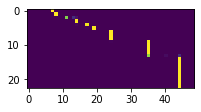

09-25 11:03:25
Mean Train Loss: 0.009429528637196658
Mean Train Seq2Seq Loss: 2.2058897618500604
Train CER: 0.6793612821936155
Eval Count 50 | 오거리에서 구로 방향으로 가면되나요 ___ => <s>오궈쇼이서 궈워 반횬고서 가면되나요?</s> => 음요 서서            나나?   


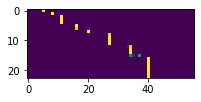

Eval Count 64 | 지금 식사 할 수 있을까요?  => <s>지금 식사할 수 ㅇ있을까요?</s> => 지금 식사 할   있까까?  


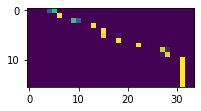

09-25 11:03:48
Mean Evaluation Loss: 0.019840760259116172
Mean Evaluation Seq2Seq Loss: 2.3557862025240315
Evaluation CER: 0.6524516419253261


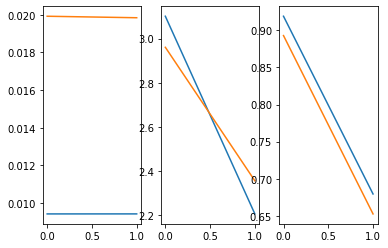

-------------------------------------------------------------------------------------------------------
09-25 11:03:48
Count 200 | 얼마나 주차할 수 있을까요? 주차가능시간이요 __ => <s>알마나 구차할 수 있을까요? 주차 가능 시간이요.</s> => 아 마 가 수수 있 주         이요요   


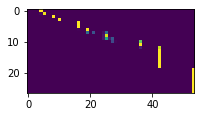

Count 400 | 웰던으로 부탁드려요 ____ => <s>웨장으로부탁드려요.</s> => 예장 부탁탁드려요      


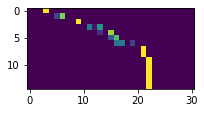

Count 600 | 공영 주차장은 따로 주차비가 나오나요? __ => <s>고묭 주차장엔 따로 주차비가나오나요?</s> => 차장 주차장이 따로 주차차나나요요      


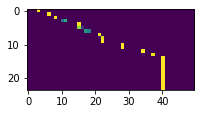

Count 800 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? _______ => <s>제졸라과 멘버스하드레 든시해느노 추이련ㅁ은 메버십 반하술 가능한지요?</s> => 제초 가가 버버  데                    능능능능  ? ? ?  ?     


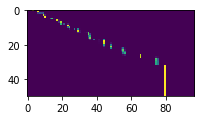

Count 808 | 몇번출구로 나가면 되나요? ___ => <s>몇번술무로 나가면 되나요?</s> => 몇번물물로로 가면면 되나요?   


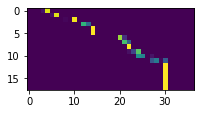

09-25 11:12:16
Mean Train Loss: 0.00943845702876534
Mean Train Seq2Seq Loss: 1.7259376136052644
Train CER: 0.5073880162885398
Eval Count 50 | 반포에서 센트럴 시티점 가는 길 좀 알려주세요 ____ => <s>다ㅡㅁ풔에 서스트워 시 티정 가능개좀안라려주세요.</s> => 카드에 서스스스      가  하      려려세세세요


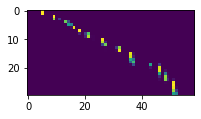

Eval Count 64 | 당일  예약도 가능한가요? __ => <s>당일 예약도 가능한가요?</s> => 당일 예약도 가능한가요?    


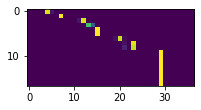

09-25 11:12:39
Mean Evaluation Loss: 0.01999204497086774
Mean Evaluation Seq2Seq Loss: 2.302651286292922
Evaluation CER: 0.5327261687917426


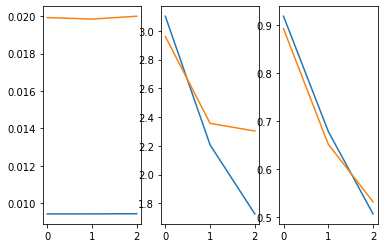

-------------------------------------------------------------------------------------------------------
09-25 11:12:39
Count 200 | 2층 창가로 예약이 가능할까요?  => <s>이층 창가로 예약이 가능할까요?</s> => 런층 창가도 예약이 가능할까요? 


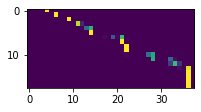

Count 400 | 통신사 할인이랑 카드할인 둘 다 쓸 수 있나요? ___ => <s>탕신사 할인이랑 카드 할인 줄다쓸 수 있나요?</s> => 통신사 할인이랑 카드 할인 둘 쓸  있있나??     


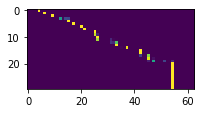

Count 600 | 멤버십 카드 할인 되나요? _ => <s>멤버십 카드 할인 되나요?</s> => 멤버십 카드 할인 되나요?  


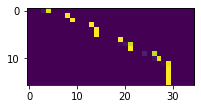

Count 800 | 아이들고 함께 먹을 메뉴 추천해주세요 __ => <s>웇*추추 마으믜춫무ㅜ춖께요.</s> => 위위주                    


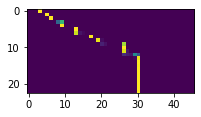

Count 808 | 오늘 저녁 6시 예약했는데 좀 늦을 것 같네요 저녁 7시로 변경할 수 있나요? ____ => <s>오늘 저녁 **시 예약했는데 좀음*샐갓 한대요 바라*ㅗㅅ시로 별ㄴ령할 수 있나요?</s> => 오늘 저녁 1시  예약했는는                 변               


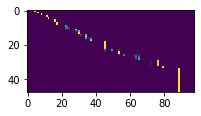

09-25 11:21:08
Mean Train Loss: 0.009440980291107326
Mean Train Seq2Seq Loss: 1.5314707725400896
Train CER: 0.44106984241865976
Eval Count 50 | 지금 오더 받으시나요? __ => <s>지그 ㅇ으저 받으시나요?</s> => 지금 유어  받으시시나요? 


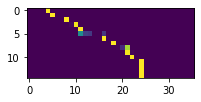

Eval Count 64 | 생일 쿠폰과 할인 중복 되나요? ____ => <s>*ㅅ*ㅇ일쿠폰과 할인 중복되나요?</s> => sk일이쿠폰과 할인 복복복되나요?    


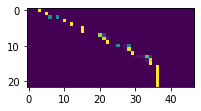

09-25 11:21:30
Mean Evaluation Loss: 0.019945027343884543
Mean Evaluation Seq2Seq Loss: 2.1049161258007
Evaluation CER: 0.4983300947291717


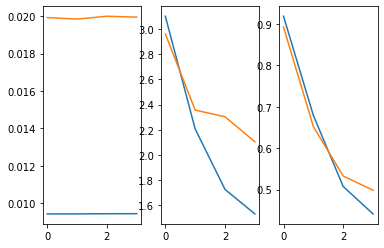

-------------------------------------------------------------------------------------------------------
09-25 11:21:31
Count 200 | 저희 부모님이 드시기에 어떤 메뉴가 좋을까요? __ => <s>자일 고몬이리모시찌에 어떤 메뉴가 톻ㅎㄶ을까요?</s> => 자일 고원이 시시어 어떤메뉴    을까요요     


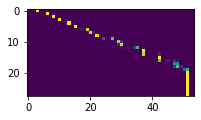

Count 400 | 멤버쉽 중복 할인 가능한가요? ____ => <s>멤버십 중복할인 가능한가요?</s> => 멤버쉽 중복할인  가가가요?      


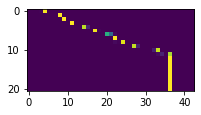

Count 600 | 앱으로 예약 가능 한가요? __ => <s>애드로 예약 가능한가요?</s> => 내로로예예약 가능한가요?    


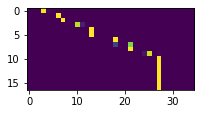

Count 800 | 네 그 골드 코스트 코코넛 쉬림프 2개를 취소하고 기브미 파이브 2개로 바꿀 수 있나요?  => <s>네 그 고드 쿠스트 코코나 시림프 ㄱ개래 치소하고 *ㅣ브리 타이브 *개로 바꿀 수 있나요?</s> => 네 그그보 코스스트코코코코코 시림 개개개개개  취하고고하하고        222222   


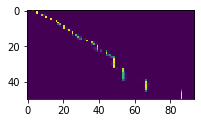

Count 808 | 예약금으로 걸어둬야하는 게 있나요? ___ => <s>예약금 으로 걸어등하는게 있나요?</s> => 예약금 으로 걸어어는는  있있있요요?   


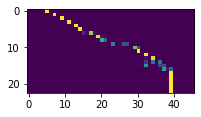

09-25 11:30:03
Mean Train Loss: 0.009414276944908187
Mean Train Seq2Seq Loss: 1.4571483612826037
Train CER: 0.4197419985148157
Eval Count 50 | 어제 예약했는데 시간 바꾸려구요 ___ => <s>어지 예약했는데 치간 바분려구요.</s> => 어디 예약했는데  간  부구구구구구  


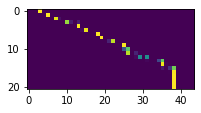

Eval Count 64 | 영업 시간 언제가 끝이죠? __ => <s>영업시간 언제각깥지죠?</s> => 영업시간 언제까지지죠죠?    


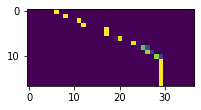

09-25 11:30:25
Mean Evaluation Loss: 0.01981853005582175
Mean Evaluation Seq2Seq Loss: 2.2617880303706612
Evaluation CER: 0.5283894810787697


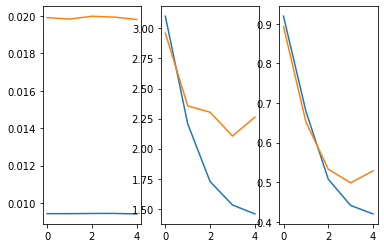

-------------------------------------------------------------------------------------------------------
09-25 11:30:26
Count 200 | 그 중에 가장 많이 나가는 메뉴가 뭔가요? ___ => <s>그지에 가장 많이나가는 메뉴가 뭔가요?</s> => 그지에 가장 많이 가는 메뉴뉴가 뭔가요      


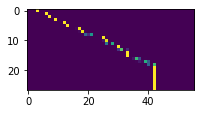

Count 400 | 영업시간이 주말엔 어떻게 되죠? ___ => <s>영업서시난이지말엔 어떻게 되죠?</s> => 영업 시시이지말에 어떻게 되죠?    


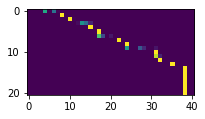

Count 600 | 라스트 오더가 몇시인가요? __ => <s>라스트 ㅗ도다 명ㅊ 시인가요?</s> => 라스트 오더 몇 시인인가?   


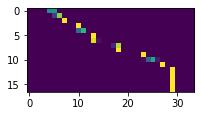

Count 800 | 아웃백 주차장이 만차이면 근처 유료주차장을 사용하고 할인 받을 수 있나요? ___ => <s>아웃백서아이만차이면 근처 이료차장으세용하고 할인 받을 수 있나요?</s> => 아웃백에서아   면면  근근    에에 용  하하  인을을             


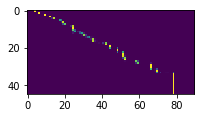

Count 808 | 점심에 가려고하는데 예약해야되나요? ______ => <s>점심에 가려고 하는데 예약해야 되나요?</s> => 점심에 가려고 하는데 예약해야 되나요?     


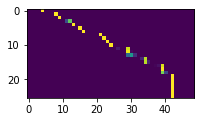

09-25 11:38:57
Mean Train Loss: 0.009428500688918949
Mean Train Seq2Seq Loss: 1.4034934058401938
Train CER: 0.39916801438348015
Eval Count 50 | 10시에도 열려 있나요? _ => <s>연치에뉴 열명 있나요?</s> => 현제휴뉴   영  나요?  


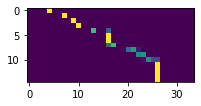

Eval Count 64 | 가족식사모임을 하려고 하는데 룸 예약가능할까요? _____ => <s>아독 식사 모 인아 하려고 하는데 무의 예약 가능할까요?</s> => 아도 식사   인아 하려고 하는데데 예예 약  능할할???


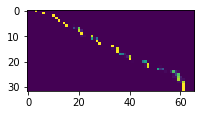

09-25 11:39:20
Mean Evaluation Loss: 0.01978138692016978
Mean Evaluation Seq2Seq Loss: 2.043832011615848
Evaluation CER: 0.4888602743007726


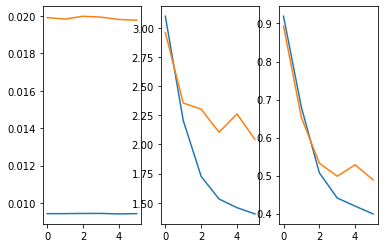

-------------------------------------------------------------------------------------------------------
09-25 11:39:20
Count 200 | 여자친구와 먹기 좋은 메뉴 좀 추천해주세요 ____ => <s>여저지과 먹기 젛은 메뉴 점로 주천해주세요.</s> => 여기과 먹기 좋은 메뉴 좀  해주주주세요      


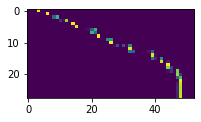

Count 400 | 내일은 언제 열어요? ____ => <s>애일듬ㄴ 언치 열아요?</s> => 내일은 언제 열아요?     


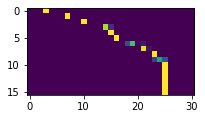

Count 600 | 평일 오픈시간을 알 수 있을까요? ____ => <s>평일 오픈시만일 알수 있을까요?</s> => 평일 오픈시간이 알 수 있을까요?     


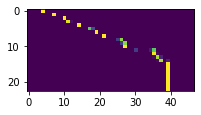

Count 800 | 단체라 인원이 많은데 다음주 일요일 오후 5시에 20명 룸으로 예약 가능할까요? _____ => <s>단체가일아이많는데 다음주요일 오후 *시ㅣ에 차운명ㅇ룸우로 예약 가능할까요?</s> => 단체 아이이이  데  음주 요요일 오후후후후       로로로로로로로로로로로        


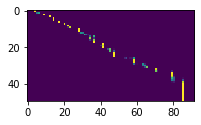

Count 808 | 영업 시간이 어떻게 되나요? _ => <s>영업 시간이 어떻게 되나요?</s> => 영업시간간이 떻게 되나요?   


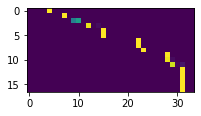

09-25 11:47:49
Mean Train Loss: 0.009449642994503212
Mean Train Seq2Seq Loss: 1.4025209324210308
Train CER: 0.4039438053815871
Eval Count 50 | 몇시간까지 무료주차죠? _ => <s>몇 시랑까지 ㅇ무루두차죠?</s> => 몇 시     무  주주?


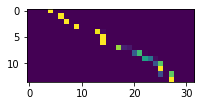

Eval Count 64 | 단체 예약 하려는데 몇 명 부터가 단체예약일까요? __ => <s>단체 예약 하이ㅕㄴ은데 몇명부타아 안시 예약있어요?</s> => 단체 예약  하 데데 몇명명        요요     


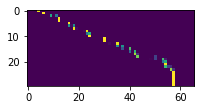

09-25 11:48:13
Mean Evaluation Loss: 0.020064092313345917
Mean Evaluation Seq2Seq Loss: 2.142335478335806
Evaluation CER: 0.5384591830485639


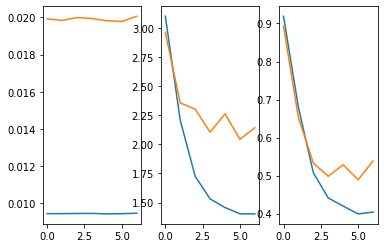

-------------------------------------------------------------------------------------------------------
09-25 11:48:13
Count 200 | 생일인 사람에게 제공되는 쿠폰이 있나요? ___ => <s>세일이차하메기 주운되는 쿠폰이 있나요?</s> => 생일이         는 쿠    있나요요?  


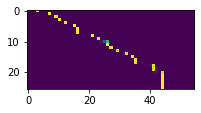

Count 400 | 점심에도 예약 되나요? __ => <s>엄심에두 예약 되나요?</s> => 점심에  예약 되나요?   


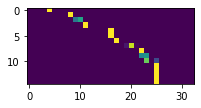

Count 600 | 여기 묻히고 가셨는데 변상해주시나요? ___ => <s>져러드 부치가가셔는데 따사하주쉬나요?</s> => 여러드 부비가가가는데데    해주시나시나??


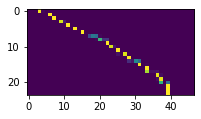

Count 800 | 혹시 이번 달에 안하는 날이 있나요? 일반적으로 영업을 안하는 날이 있나요? _______ => <s>ㅏㄱ새 이 만다에 않하는나이 이나요? 뜨만쳥료영안 아 아라는 날인 있나요?</s> => 학생 만당에   는는   나나            면     있 있  요? ??      


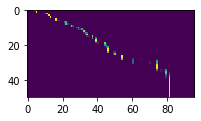

Count 808 | 네 2명 예약 부탁드립니다 __ => <s>네 *명 예약 부탁드립니다.</s> => 네 5명 예약 부탁드립립    


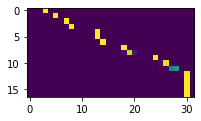

09-25 11:56:43
Mean Train Loss: 0.0094283203016208
Mean Train Seq2Seq Loss: 1.4448698328011393
Train CER: 0.4248963421061879
Eval Count 50 | 예약을 하려면 어떻게 해야 하나요? __ => <s>예약을 핟여면 어ㅓ떻게 해야 하나요?</s> => 예약을  면  어떻게 해야 하나요?   


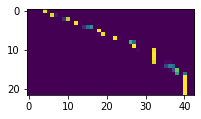

Eval Count 64 | 폭립셋트 2개 주문하려구요 직접 가지러 가겠습니다 ___ => <s>고히셀츠 프개 주루할려ㅏ개요 추처 가치롬 하겠습니다.</s> => 고 친를 스개  주 를                 습습


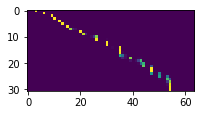

09-25 11:57:06
Mean Evaluation Loss: 0.02006457921318386
Mean Evaluation Seq2Seq Loss: 2.0565726152833337
Evaluation CER: 0.48696293111390926


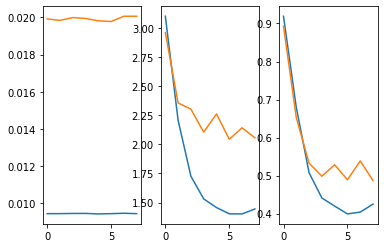

-------------------------------------------------------------------------------------------------------
09-25 11:57:06
Count 200 | 싸갈수 있을까요? ___ => <s>카ㅏ랄 수 있을까요?</s> => 싸갈 수 있을까요?   


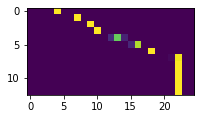

Count 400 | 아 네 투움바파스타랑 오지치즈후라이 배달 되나요? __ => <s>아느 추움마파스타ㅏ라 모디치주무하이 배달 되나요?</s> => 아늘 투움바파스타타타  다 시지 주주  배 나나?   


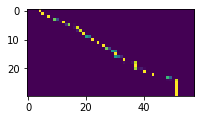

Count 600 | suv 차량도 주차가 가능한 곳인가요? _ => <s>ㅈ*무 차랑도 주차 가능한곳인가요?</s> => 20 차차장도 주차가가능능 요요??    


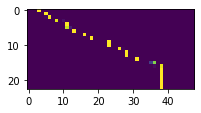

Count 800 | 네 맞아요 얼마나 걸리나요? _ => <s>넬 마자ㅛ 얼마나 걸리나요?</s> => 네 마마  얼마나 걸리나요?  


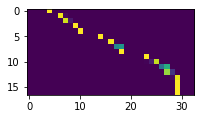

Count 808 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? _______ => <s>아추송한네 메벼시 바드르 브시했는데 아지 이모르로벤봇시 워워주이하능한지요?</s> => 아차순천에 멤버  드드를  시했는는  지   로로  목       지 지지지 지지지?지지 


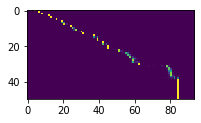

09-25 12:05:37
Mean Train Loss: 0.009439001569103508
Mean Train Seq2Seq Loss: 1.3862800034879907
Train CER: 0.3975513048967327
Eval Count 50 | 오늘 쉬는날 인가요? ___ => <s>고르ㅡㄴ 시난달인가요?</s> => 국는 시만 인인인가요?   


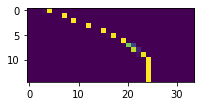

Eval Count 64 | 10명 단체인데 앉을 자리 있나요? __ => <s>**명 단체 인데 앉제 사리 있나요?</s> => 10명 단체 인데    자  있나요?  


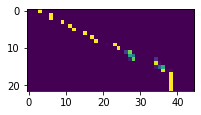

09-25 12:06:00
Mean Evaluation Loss: 0.019740764761540346
Mean Evaluation Seq2Seq Loss: 1.9901074682036701
Evaluation CER: 0.5083030303030303


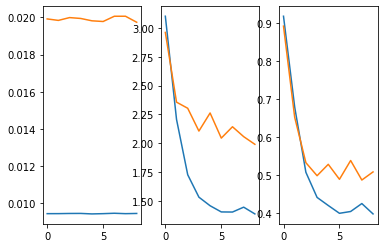

-------------------------------------------------------------------------------------------------------
09-25 12:06:00
Count 200 | 아웃백 신사점 배달도 되나요? ___ => <s>아웃백시사점 배달도 되나요?</s> => 아웃백 식점 배달도 되나요?     


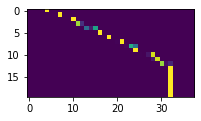

Count 400 | 이번주 일요일에 예약했는데 취소해야겠습니다 _____ => <s>이번주 일요일에ㅖ ㅖ약했는데 추소해 약엤습니다.</s> => 이번주 일요일  예약했는데 취소해야 겠습습니다    


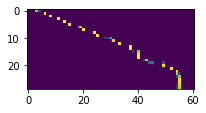

Count 600 | 런치 할인 메뉴 알려 주세요  => <s>런치 할인 메뉴 알려주세요</s> => 런치 할인 메뉴 알려주세요  


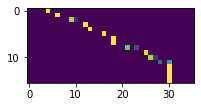

Count 800 | 혹시 할인되는 제휴 카드 뭐 있어요? __ => <s>학시 할인되는 제흉카드 뭐 있어요?</s> => 학시 할인되는 휴휴카드 뭐있있요?     


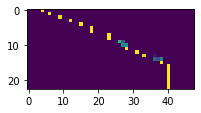

Count 808 | 차타고 가고 있는데 신세계백화점 맞은편 대로에서 어느 골목으로 들어가야하나요? ______ => <s>차차고 가고있는데 지순여세가전 마은차른 채도으ㅣ서 어먹고어으로 그어가야하나요?</s> => 차차구 가고 있는데  역역 서            느  어 야 나 나            


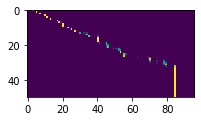

09-25 12:14:29
Mean Train Loss: 0.009427014362225185
Mean Train Seq2Seq Loss: 1.4112114120295804
Train CER: 0.4140368128322527
Eval Count 50 | 단체석 몇명까지되나요 ___ => <s>단체석 몇 명까지 되나요?</s> => 단체석 몇 까까지 되나요? 


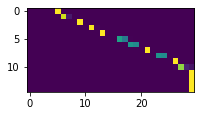

Eval Count 64 | 아그럼 그냥 예약 취소해주세요 ______ => <s>아 그럼며 군유아 예약 취소해ㅐ주세요.</s> => 아 그럼러  구    취취소해해 주요요  


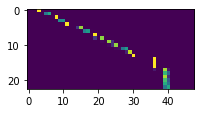

09-25 12:14:52
Mean Evaluation Loss: 0.01990395143624659
Mean Evaluation Seq2Seq Loss: 2.0094175646968826
Evaluation CER: 0.4942563574091474


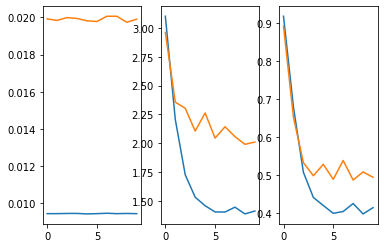

-------------------------------------------------------------------------------------------------------
09-25 12:14:52
Count 200 | 영업 언제부터 헤요? _ => <s>영업 언제부터 옝ㄱㄴ ㅏㅈ에요?</s> => 영업 언제부터 금  제에


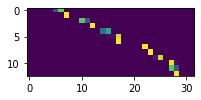

Count 400 | 단체 예약하려는데 룸이 있나요? ____ => <s> 단체 예약 가려는데 룸이 있나요?</s> => 단체 예약 가는데 룸이 있나요?     


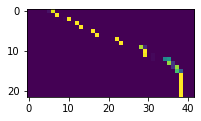

Count 600 | 안녕하세요 3시쯤 도시락 포장해가려는데 가능할까요? _____ => <s>안녕하세요 세스삼 더시가포당하다라는데 가능한가알까요?</s> => 안녕하세요  사  시시  포  는데 가능할까요?        


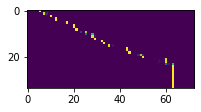

Count 800 | 어린이 날에도 영업하나요? ___ => <s>어린이 날에도 영업하나요?</s> => 어린이 날에도 영업하나요?    


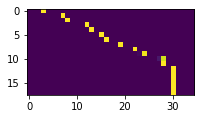

Count 808 | 5세 아이가 먹을만한 메뉴가 있나요? __ => <s>*데 알이가 먹을만한 메뉴가 있나요?</s> => 2데  이가 먹을만한 메뉴가 있나요?   


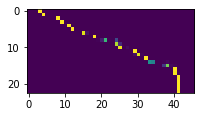

09-25 12:23:21
Mean Train Loss: 0.009440924094374532
Mean Train Seq2Seq Loss: 1.3900812464981065
Train CER: 0.4037243898797762
Eval Count 50 | 아기의자는 몇살까지 앉을 수 있는 의자인가요? ____ => <s>아기의자는 몇살까지 앉을 수 있으 수 있나요?</s> => 아기의자는    까지       있있있요요?      


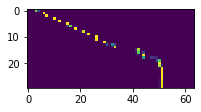

Eval Count 64 | 파스타 종류가 어떻게 되나요?  => <s>파스타 좀류가 ㅓ때 되나요?</s> => 파스타 종류가 어떻 되나요?  


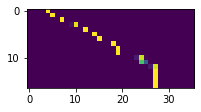

09-25 12:23:44
Mean Evaluation Loss: 0.019768890767278356
Mean Evaluation Seq2Seq Loss: 1.9956926577206255
Evaluation CER: 0.49160475931630127


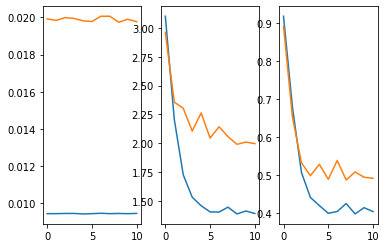

-------------------------------------------------------------------------------------------------------
09-25 12:23:44
Count 200 | 지금 영업 하나요? __ => <s>주금 영업 하나요?</s> => 주금 영업 하나요?   


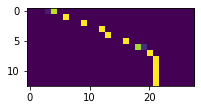

Count 400 | 단체 할인은 몇 명부터 되나요? __ => <s>단체 할인인 몇명부터 되나요?</s> => 단체 할인  몇명부터터되되나??   


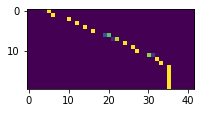

Count 600 | 단체 예약하고 싶은데 어떻게 하는지 알 수 있을까요? ___ => <s>단체예약하고 싶은데 어떻게 아은징얄 수 있을까요?</s> => 단체 예약하고 싶은 어떻게       수 있을까요?     


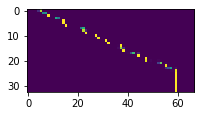

Count 800 | 30명 단체 주문 가능해요? _ => <s>**명 단체 주문 가능해요?</s> => 10명 단체 주문 가능해요?  


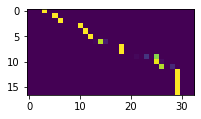

Count 808 | 예약 사항을 좀 바꿀 수 있을까요? ___ => <s>예약 사항을줌 바꿀 수 있을까요?</s> => 예약  항을 좀꿀 수  있요요?      


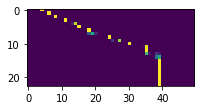

09-25 12:32:13
Mean Train Loss: 0.009417065202842396
Mean Train Seq2Seq Loss: 1.3687662770429043
Train CER: 0.39858046035086486
Eval Count 50 | 몇사람까지 가능한가요? __ => <s>몇사랑까지 가능한가요?</s> => 몇사사까까 가능한가요?   


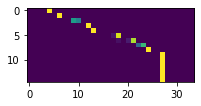

Eval Count 64 | 주중이랑 주말이랑 브레이크 타임 시간이 다른가요? _____ => <s>주중이랑 주말이랑 브레이이크 타임 시간이 다료른가요?</s> => 주중이랑 주말이랑랑 브레이크 타임 시간  다다가 가     


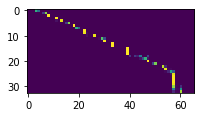

09-25 12:32:36
Mean Evaluation Loss: 0.01981348814638092
Mean Evaluation Seq2Seq Loss: 2.0861306723767035
Evaluation CER: 0.5282694198623402


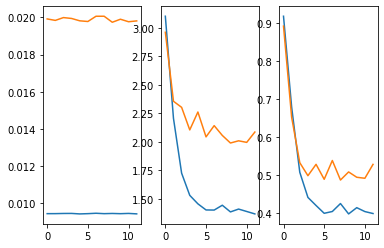

-------------------------------------------------------------------------------------------------------
09-25 12:32:36
Count 200 | 9시에도 영업하나요?  => <s>*시에도 영업하나요?</s> => 9시에도 영업하나요? 


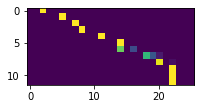

Count 400 | 문화상품권으로 결재 가능한가요? ___ => <s>은자순품관으로 대재 가능한가요?</s> => 은자 품권은로 대대 가능한가요?    


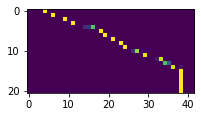

Count 600 | 대중교통으로 가는 게 낫나요 아니면 차로 가는 게 낫나요 __ => <s>투층 도통흐로가는 게 나나요 아니년 차로 가는게 앗나요?</s> => 주통 보통으로가 게 나나요 아니면 차차   게  낫나요?   


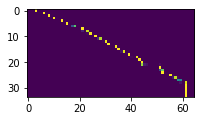

Count 800 | 가까운 지점이 또 있나요? ___ => <s>가까운치잠이이조 있나요?</s> => 가까운  이이  있있나요?    


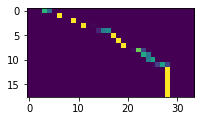

Count 808 | 평일 런치가 몇시부터 몇시까지인가요? __ => <s>평일을 먼치가 몇 시붑터 몇시까지인가요?</s> => 평일은 치치가 몇시시부터 몇몇시까인가요? 


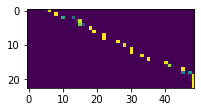

09-25 12:41:08
Mean Train Loss: 0.009468502509052852
Mean Train Seq2Seq Loss: 1.430428444902709
Train CER: 0.4253558837771336
Eval Count 50 | 단체 할인이 있나요? ___ => <s>단차 할인이 있나요?</s> => 단체 할인이 있나요?    


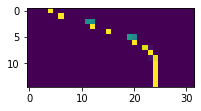

Eval Count 64 | 베이비 백립은 지금 팔고 있나요? ____ => <s>세이 이믄유는 지윤 파료 있나요?</s> => 생일 모이는  용    있요?       


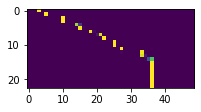

09-25 12:41:31
Mean Evaluation Loss: 0.01979674355579025
Mean Evaluation Seq2Seq Loss: 2.000965050358393
Evaluation CER: 0.5329070965396037


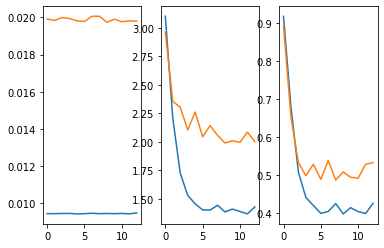

-------------------------------------------------------------------------------------------------------
09-25 12:41:31
Count 200 | 런치타임 할인 메뉴가 있나요? ___ => <s>런치타임 할인 뫼뉴가 있나요?</s> => 런치타임 할인  가  있나요?    


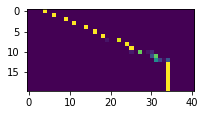

Count 400 | 예약을 좀 하고 싶은데요 언제 언제가 비나요? ___ => <s>예약을 온화고 싶은데요 언제 언제바 되나요?</s> => 예약을 오고고  은데  언 언제제     요?    


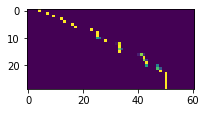

Count 600 | 방문 포장하려고 합니다 _____ => <s>밤문포장하려고 합니다.</s> => 방문포포장하려고 합니다      


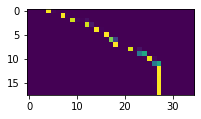

Count 800 | skt gold회원은 할인이 얼마나 되죠?  => <s>****ㅡ느원은 할인이 얼마나 되죠?</s> => kktt는 은 할인이 얼  나 되죠     


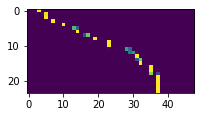

Count 808 | 전화로만 예약이 가능한가요? 앱으로도 예약할 수 있나요? 예약 방법 알려주세요 ______ => <s>전화ㅗ만예약ㅇ 가능한가요? 매브로고 예약할 수 있나요? 예약 방봅 알려주세요.</s> => 전화  약약  가가가가가?   번로로토   약    로         구구구구구구 구   


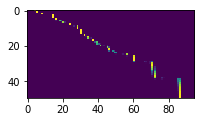

09-25 12:50:01
Mean Train Loss: 0.009435800517271779
Mean Train Seq2Seq Loss: 1.4125609054829849
Train CER: 0.4060012301203761
Eval Count 50 | 지금 혹시 배달되나요? __ => <s>주흄 혹시ㅔㄱ 브달 되나요?</s> => 지금 혹시  발  되나요? 


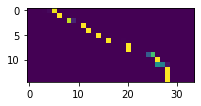

Eval Count 64 | 언제가면 웨이팅이 제일 적을까요? ____ => <s>잔사가느 므 이 이지에촣옪은가요?</s> => 잠사가가    이 에에   요요 ?    


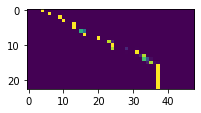

09-25 12:50:24
Mean Evaluation Loss: 0.019655289829599642
Mean Evaluation Seq2Seq Loss: 1.9815500565897097
Evaluation CER: 0.49829547168672883


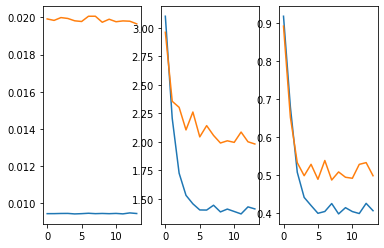

-------------------------------------------------------------------------------------------------------
09-25 12:50:24
Count 200 | 카운터 보시는 분 전화번호 알 수 있을까요? ___ => <s>카우터퍼시는 분 전하분후 알 수 있을까요?</s> => 카운터스스는 분전전화       있을까요?     


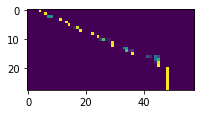

Count 400 | 할인 이벤트 있나요? __ => <s>할인 이벤트 있나요?</s> => 할인 이벤트 있나요?   


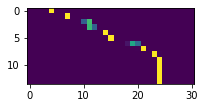

Count 600 | 생일 할인은 어떻게 쓸 수 있나요? ___ => <s>생일 할인으ㅡㄴ 어떻게 쓸 수 있나요?</s> => 생일 할인은 어어떻게 쓸 수 있나요?   


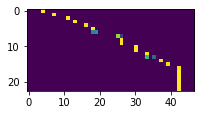

Count 800 | 지하철 몇번 출구로 나오면 되는지 지하철역에서 어떻게 가면 되는지 궁금합니다 _______ => <s>지하철 몇 번 추구로 나오하대ㅐㄴ 데이 치추익메서 ㅓ덯게 가년 죄는지 궁ㅁ가합니다.</s> => 지하철 몇번주 나          비에   어 가가 가가 가가 가는  니 니다다합합니다다 


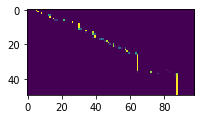

Count 808 | 공휴일에도 영업을 하나요? ___ => <s>겅휴ㅣㄴ에도 영업을 하나요?</s> => 휴휴에도 영업업 하나요?     


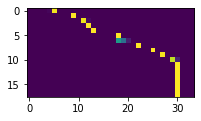

09-25 12:58:54
Mean Train Loss: 0.009412447352325834
Mean Train Seq2Seq Loss: 1.4110194041473598
Train CER: 0.4159851129802786
Eval Count 50 | 생일 할인 받으려면 증명 어떻게 해야하나요? ______ => <s>생일 할인 받으려면 진명 어떻게 해야 하나요?</s> => 생일 할인 받으면면    어떻  해야 하나????하 하?


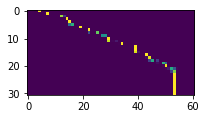

Eval Count 64 | 추석 당일에도 영업하나요? __ => <s>추석 당일에도 영업 하나요?</s> => 추석 당일에도영영업업 하나요? 


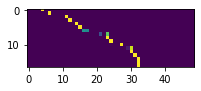

09-25 12:59:17
Mean Evaluation Loss: 0.01978170263328724
Mean Evaluation Seq2Seq Loss: 2.2479039000696472
Evaluation CER: 0.5600384245917387


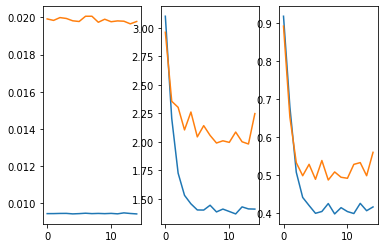

-------------------------------------------------------------------------------------------------------
09-25 12:59:17
Count 200 | 발렛파킹 해주나요? __ => <s>발레파킹 해ㅜ 주나요?</s> => 발레파킹해해 주나요?  


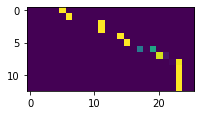

Count 400 | 이 메뉴는 아가가 먹을 수 있나요? _ => <s>이메뉴느아따나 먹을 수 있나요?</s> => 이메뉴뉴 가   을 수 있나요?    


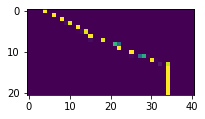

Count 600 | 갑각류 알러지가 있는 사람에게 맞는 스파게티가 있나요? ___ => <s>가깡ㅁ여할려지가 이는 사란이이많으 주차리가 됬나요?</s> => 가까역 려려 지     람람이 이이  차차차   나나?    


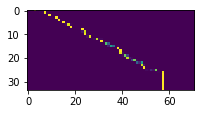

Count 800 | 룸으로 된 자리가 있나요? ___ => <s>움으로된 자리괴 있나요?</s> => 금으로  자자리 있있요요?    


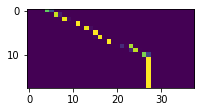

Count 808 | 지하철 몇번 출구가 가장 가까운가요? __ => <s>치사 철몇던 추구거 가장 가앝운가요?</s> => 식사 몇번   출가 가가 같 요가?????


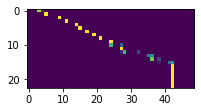

09-25 13:07:51
Mean Train Loss: 0.009439953182194044
Mean Train Seq2Seq Loss: 1.4300408313534212
Train CER: 0.418694190058916
Eval Count 50 | 런치타임은 몇시부터죠? _ => <s>런치타임은 몇시구터죠?</s> => 런치타은 몇시터죠죠?   


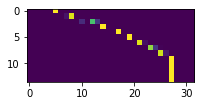

Eval Count 67 | 투움바 파스타 포장이 되나요?  => <s>투움부파스타ㅗ 파낭히 되나요?</s> => 투움바파스타   매 되나나?  


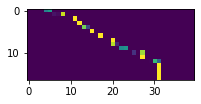

09-25 13:08:16
Mean Evaluation Loss: 0.019838524379212522
Mean Evaluation Seq2Seq Loss: 2.0862349828360744
Evaluation CER: 0.559123492044991


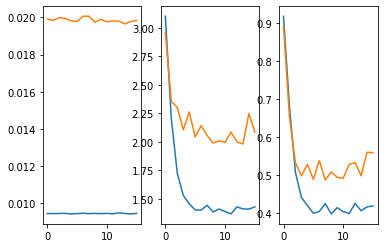

-------------------------------------------------------------------------------------------------------
09-25 13:08:16
Count 200 | 예약 어떻게 해요? __ => <s>예약 어떻게 해요?</s> => 예약 어떻게 해요?   


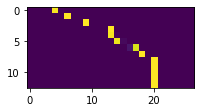

Count 400 | 4살 정도 되었는데 먹을 수 있는 메뉴 있나요? __ => <s>재잘정도되랐는데 먹을 수 있는 메뉴 있나요?</s> => 재장동 도도되렸는데 먹을 수 있는 메뉴 있나요?   


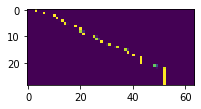

Count 600 | 근처에 가면 아웃백이 바로 보이나요? __ => <s>근처에 가면 아웃백이 바로 보이나요?</s> => 근처에 가면 아웃백이 바로 보나나요?   


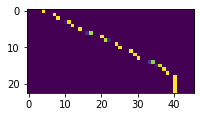

Count 800 | 공휴일엔 몇시 오픈하나요? ___ => <s>공휴일ㄹㄴ 몇 싱 오픈하나요?</s> => 공휴                


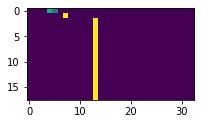

Count 808 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? _______ => <s>죄소한데  애버십 카드 부시해는대 춘운부르로 멤버십퍼로수흘 가능한지요?</s> => 죄송                                                


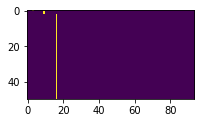

09-25 13:17:05
Mean Train Loss: 0.009435794317542084
Mean Train Seq2Seq Loss: 1.5224908629648375
Train CER: 0.4431520077779773
Eval Count 50 | 디너전에 주차 미리해두면 몇시간 주차 가능할까요? _ => <s>이버서에 주차 미리도면 몇시간 주차 가능할까요?</s> => 파번에                          


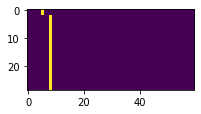

Eval Count 64 | 창가자리 예약 가능한가요? _ => <s>창차 자리 예약 가능한가요?</s> => 창체              


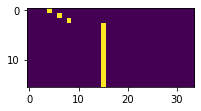

09-25 13:17:28
Mean Evaluation Loss: 0.019864011988940545
Mean Evaluation Seq2Seq Loss: 3.194213810705125
Evaluation CER: 0.9190402051469915


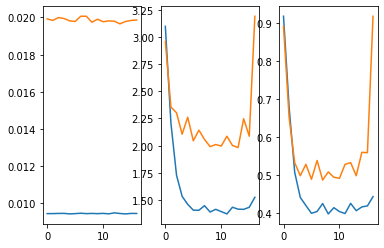

-------------------------------------------------------------------------------------------------------
09-25 13:17:28
Count 200 | 6시 정도에 4명분 자리 하나 좀 부탁드립니다 __ => <s>ㅁ*소시 장맬 메명 눈 차리 하낭 준 부탁드립니다.</s> => 20시 정  메명   자      부탁드드니니다  


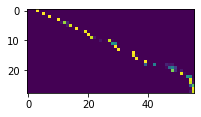

Count 400 | 몇시까지 가면 주문할 수 있나요? _ => <s>몇 시까지 가면 주문할 수 있나요?</s> => 몇 시까지 가면 주문할 수 있나요? 


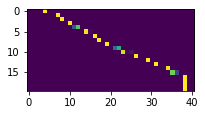

Count 600 | 설에도 매장 오픈 하나요? __ => <s>설욜도 매장 오픈 하나요?</s> => 설날도 매장 오픈 하나요?   


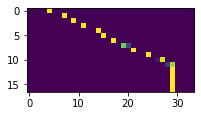

Count 800 | 네 그 골드 코스트 코코넛 쉬림프 2개를 취소하고 기브미 파이브 2개로 바꿀 수 있나요?  => <s>네 그르 골드 소스트크콘어 쉬이크 추랠르 치서ㅏ고 기무ㅣ 다일*ㅡ*ㄴ개로 바꼴 수 있나요?</s> => 네 그럼 골들  코코코코코 코코크크 코  취치    기기                   


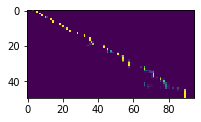

Count 808 | 평일 오픈시간을 알 수 있을까요? ____ => <s>새묘 오픈 시간을 마알 수 있을까요?</s> => 새로 오픈 시간을 알 수 있을까요?    


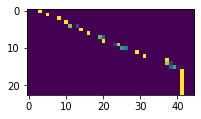

09-25 13:26:01
Mean Train Loss: 0.009444613627854148
Mean Train Seq2Seq Loss: 1.3881190182248453
Train CER: 0.40359476765980584
Eval Count 50 | 지금 단체로 15명 가는데 앉을 자리 있을까요? __ => <s>지금 단체악*ㅔㄹ *러면가는 대 엱틀 자리 갔욀까요?</s> => 지금 단체       가      자리 가가 까요? 


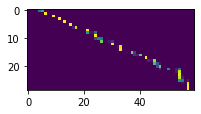

Eval Count 64 | 방문 포장하려고 합니다 ____ => <s>방문 포장 하려고 합니다.</s> => 방문 포장 하려고 니니다    


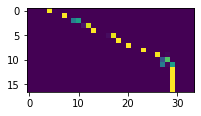

09-25 13:26:24
Mean Evaluation Loss: 0.019831757571449803
Mean Evaluation Seq2Seq Loss: 1.948595112222716
Evaluation CER: 0.4946734035429476


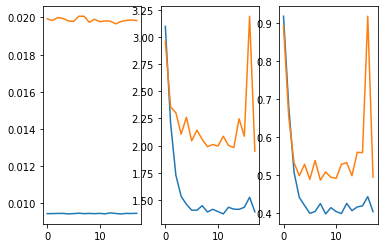

-------------------------------------------------------------------------------------------------------
09-25 13:26:24
Count 200 | 2시부터 3시 사이에 브레이크 타임이 있나요?  => <s>고시부터 새시사이에 브레이크 타임이 있나요?</s> => 혹시부   시에에 브레이크크 타임이 있요요?  


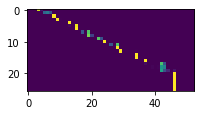

Count 400 | 자극적이지 않은 메뉴가 있나요? ___ => <s>자곡적이지 않은 메뉴가 있나요?</s> => 가족  기 않은 메뉴가 있나요?    


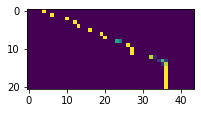

Count 600 | 오늘 몇시까지 영업하나요? __ => <s>오늘 몇시까지 영업하나요?</s> => 오늘               


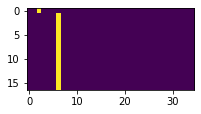

Count 800 | 이번주 목요일 낮 12시에 예약 했는데요 인원과 날짜를 변경 하고 싶은데요 ___ => <s>이번주 목요일남 ***시 에ㅣ 예약했는데요 위웡ㄴ과 날사를 젼경하고 싶은데요.</s> => 예                                            


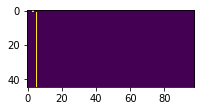

Count 808 | 오늘 5시쯤 방문해서 찾으러 가려구요 ___ => <s>어차ㅏ시즌 방무해서 차지로 가려구요.</s> => 안녕                      


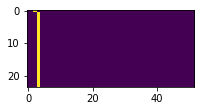

09-25 13:34:55
Mean Train Loss: 0.009438580279519404
Mean Train Seq2Seq Loss: 2.4222587466761163
Train CER: 0.6997276321182553
Eval Count 50 | 여기 남은거 포장되나요? _ => <s>역기 나문거 포장ㅇ 되나요?</s> => 안              


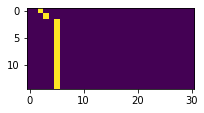

Eval Count 64 | 런치세트로 밥을 먹고 싶은데 어떤 종류가 있나요? ___ => <s>런치 세츠 받을 갇고 싶은데 어떠언 종류가 있나요?</s> => 런치                             


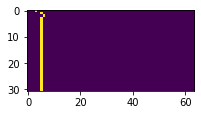

09-25 13:35:17
Mean Evaluation Loss: 0.019741295434338186
Mean Evaluation Seq2Seq Loss: 3.427336299902133
Evaluation CER: 0.9713592378441535


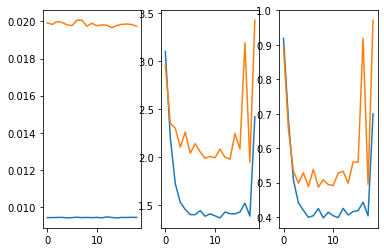

-------------------------------------------------------------------------------------------------------
09-25 13:35:18
Count 200 | 할인 쿠폰 같은 것 어디서 받을 수 있나요? ___ => <s>할인쿠폰 같은거 어디서 받을 수 있나요?</s> => 할인쿠폰 같은거 어디  을을 수  나요요      


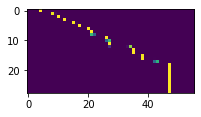

Count 400 | 8명 예약 가능한가요? _ => <s>**명 예약 가능한가요?</s> => 10명 예약 가능한가요? 


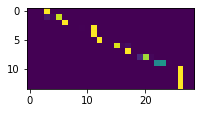

Count 600 | 사거리에서 난곡쪽으로 가는게 맞나요? ___ => <s>사권에에서 만우ㅗㄱ 속으로 가능게 ㅁㅈ나요?</s> => 3간에에서      으로  게게 맞나요?? 


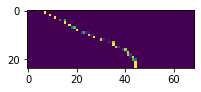

Count 800 | 다음주 월요일 4시에 10명 예약했는데 혹시 13명으로 인원 변경이 가능한가요? _____ => <s>다ㅡㅁ초 워용*ㄹ *시에 **명 예약했는덱시* ㅅ**명으워 인면 뎐경이 가능한가요?</s> => 다음  월 일    2명명 명  했는데데   명명명      경   가가가가가가 가 가  


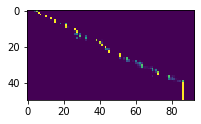

Count 808 | 파티 메뉴 추천 부탁드려요 __ => <s>파시 메는 수천 브차그려요.</s> => 파시 메는 추천 부탁려려요   


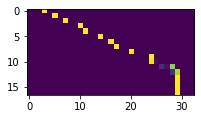

09-25 13:43:47
Mean Train Loss: 0.009420644403045799
Mean Train Seq2Seq Loss: 1.384921733069458
Train CER: 0.40077461785665613
Eval Count 50 | 건물 몇층에 있나요? ___ => <s>간무일 몇층에 있나요?</s> => 설이일 몇층에 있나요?   


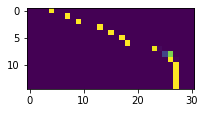

Eval Count 64 | 저기 지금 이마트가 보이는데 이마트 오른쪽에 있나요? _ => <s>아기 즈르 이가드가포있은데 이마통로 ㅐ쭉게 있나요?</s> => 아기    기가 가   있는데데데  로로로        


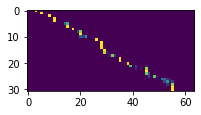

09-25 13:44:11
Mean Evaluation Loss: 0.019951165550732786
Mean Evaluation Seq2Seq Loss: 2.008639279125441
Evaluation CER: 0.5164777947932618


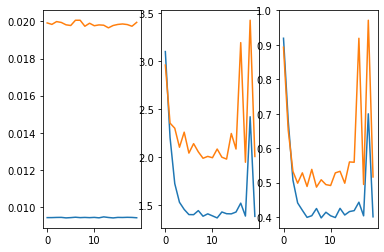

-------------------------------------------------------------------------------------------------------
09-25 13:44:11
Count 200 | 설날에 문 여나요? _ => <s>설날에 문 여나요?</s> => 설날에  문 열 요요?


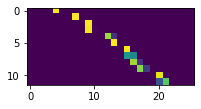

Count 400 | 오늘 갈건데 지금 영업 하나요? ____ => <s>오늘 갈건데 시근 영업하나요?</s> => 오늘 갈건데 시시 영영하나나요??    


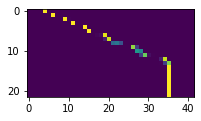

Count 600 | 지금 저녁식사 하러 가는 중인데 혹시 주차장이 있나요? __ => <s>지금 자녁 식차하하러가는주ㅜㄴ데 혹시 주차장이 있나요?</s> => 지금 저녁 식사하가가가는데   시시 차차이이있있나요     


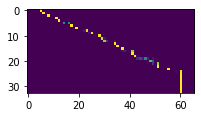

Count 800 | 파티룸 예약 가능한가요? ___ => <s>파티뤄 예약 가능한가요?</s> => 파트룸 예약 가능한가요?    


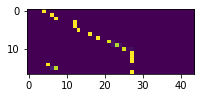

Count 808 | 감사합니다 많은 도움이 되었어요 _____ => <s>감사합니다 시많음 소몸 미되 앗ㅆ어요.</s> => 감사합니다 시락은  소           


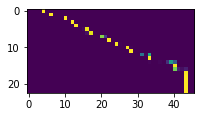

09-25 13:52:39
Mean Train Loss: 0.009433543452764237
Mean Train Seq2Seq Loss: 1.6022324551030163
Train CER: 0.47654091817681143
Eval Count 50 | 미리 주문해놔도 되나요? _ => <s>기 주문흐 마도 되나요?</s> => 지 주문문  도 되되나요? 


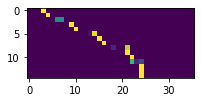

Eval Count 64 | 지금 예약 가능한 자리가 있나요? ___ => <s>지금 예약가능한 자리가 있나요?</s> => 지금 예약 가능한 자리가 있나요?    


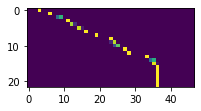

09-25 13:53:02
Mean Evaluation Loss: 0.019850440328440862
Mean Evaluation Seq2Seq Loss: 2.098474042436602
Evaluation CER: 0.5334929679922406


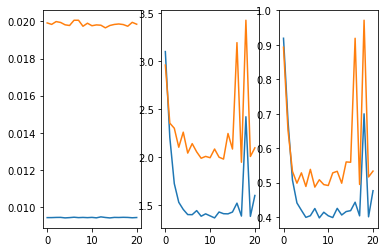

-------------------------------------------------------------------------------------------------------
09-25 13:53:03
Count 200 | 어른들이 가장 많이드시는 메뉴는 뭐가있나요? __ => <s>어른들이 가장 많이 들실ㅆ는 메뉴는 뭐가있나요?</s> => 어울이들 가장 많이  실있는 메뉴는 뭐뭐있나요? 


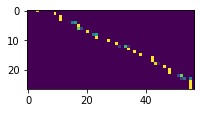

Count 400 | 문화상품권으로 결재 가능한가요? __ => <s>무나상폰깐으로 혈재 가능한가요?</s> => 아늘 방문         가 한   


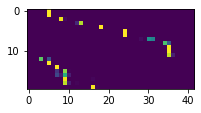

KeyboardInterrupt: 

In [30]:
EPOCH = 6 * 10
           
# net = Mel2SeqNet(80, 512, 256)


# net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)

# keyword = 'NSML_pure_jamo_50ms_pad_cut'
# net = Mel2SeqNet(80, 512, 256, len(unicode_jamo_list), device)

# keyword = 'NSML_pure_jamo_50ms_pad_cut_1024'

keyword = 'NSML_pure_jamo_50ms_pad_cut_1024_copy'

net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)
net_optimizer = optim.Adam(net.parameters(), lr=0.001)
ctc_loss = nn.CTCLoss().to(device)

try:
    load(net, net_optimizer, 'model_saved/{}'.format(keyword))
except:
    print('Failed to load model')

keyword = 'NSML_seq2seq_both_model_256_selective_model_save_2'

jamo2char_net = Seq2SeqNet(256, jamo_tokens, char2index, device)
jamo2char_optimizer = optim.Adam(jamo2char_net.parameters(), lr=0.001)
seq2seq_criterion = nn.NLLLoss(reduction='none').to(device)

train_loss_history = list()
eval_loss_history = list()

train_seq2seq_loss_history = list()
eval_seq2seq_loss_history = list()

train_cer_history = list()
eval_cer_history = list()

try:
    train_cer_history = list(np.load('model_saved/train_cer_history_{}.npy'.format(keyword)))
    eval_cer_history = list(np.load('model_saved/eval_cer_history_{}.npy'.format(keyword)))
except:
    print("No CER Record")
    
try:
    load(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    train_seq2seq_loss_history = list(np.load('model_saved/train_seq_loss_history_{}.npy'.format(keyword)))
    eval_seq2seq_loss_history = list(np.load('model_saved/eval_seq_loss_history_{}.npy'.format(keyword)))
except:
    print('No Seq2Seq Loss Record')
    
try:
#     load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    train_loss_history = list(np.load('model_saved/train_loss_history_{}.npy'.format(keyword)))
    eval_loss_history = list(np.load('model_saved/eval_loss_history_{}.npy'.format(keyword)))
except:
    print("Loading {} Loss History Error".format(keyword))

# keyword = 'NSML_pure_jamo_50ms_pad_cut_1024_copy'

min_loss_net = 1e+10
min_loss_seq = 1e+10

for epoch in range(EPOCH):

    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    
    try:
        load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    except:
        print('Could not found model_saved/{}'.format(keyword))
        
    try:
        load(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    except:
        print('Could not found model_saved/seq_{}'.format(keyword))

    preloader_train.initialize_batch(num_thread)
    loss_list_train = list()
    seq2seq_loss_list_train = list()

    total_dist = 0
    total_length = 0
    count = 0
    net.train()
    jamo2char_net.train()
    
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        # logger.info("Got Batch")
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth, lev_truth_loss_mask = batch
            pred_tensor, loss = evaluate(net, ctc_loss, tensor_input.to(device),
                                      ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)

            jamo_result = Decode_Prediction_No_Filtering(pred_tensor, tokenizer)
            
            lev_input = ground_truth
            lev_pred, attentions, seq2seq_loss = jamo2char_net.net_train(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), jamo2char_optimizer, seq2seq_criterion)
            
            lev_input = Decode_Jamo_Prediction_And_Batch(pred_tensor)

            
            lev_pred, attentions, seq2seq_loss = jamo2char_net.net_train(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), jamo2char_optimizer, seq2seq_criterion)
            
            seq2seq_loss_list_train.append(seq2seq_loss)
        
            pred_string_list = Decode_Lev(lev_pred, index2char)
            true_string_list = Decode_Lev_Truth(lev_truth.detach().cpu().numpy(), index2char)
            dist, length = char_distance_list(true_string_list, pred_string_list)
            
            total_dist += dist
            total_length += length
            
            count += 1
            if count % 200 == 0:
                print("Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
                plt.figure(figsize = (3, 3))
                plt.imshow(attentions[0].detach().cpu().numpy().T)
                plt.show()
            
        
    print("Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
    plt.figure(figsize = (3, 3))
    plt.imshow(attentions[0].detach().cpu().numpy().T)
    plt.show()

    train_cer = total_dist / total_length
    train_loss = np.mean(np.asarray(loss_list_train))
    train_seq2seq_loss = np.mean(np.asarray(seq2seq_loss_list_train))
    
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Train Loss: {}".format(train_loss))
    print("Mean Train Seq2Seq Loss: {}".format(train_seq2seq_loss))
    print("Train CER: {}".format(train_cer))
    
    train_loss_history.append(train_loss)
    train_cer_history.append(train_cer)
    
    train_seq2seq_loss_history.append(train_seq2seq_loss)
    
    ###########################################################
    
    preloader_eval.initialize_batch(num_thread)
    loss_list_eval = list()
    seq2seq_loss_list_eval = list()

    total_dist = 0
    total_length = 0
    
    net.eval()
    jamo2char_net.eval()
    
    count = 0
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth, lev_truth_loss_mask = batch
            pred_tensor, loss = evaluate(net, ctc_loss, tensor_input.to(device),
                                      ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)
            
            jamo_result = Decode_Prediction_No_Filtering(pred_tensor, tokenizer)
            
#             lev_input = Decode_Jamo_Prediction_And_Batch(pred_tensor)
            lev_input = ground_truth
            lev_pred, attentions, seq2seq_loss = jamo2char_net.net_eval(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), seq2seq_criterion)
        
            lev_input = Decode_Jamo_Prediction_And_Batch(pred_tensor)
            lev_pred, attentions, seq2seq_loss = jamo2char_net.net_eval(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), seq2seq_criterion)
            seq2seq_loss_list_eval.append(seq2seq_loss) ###############
        
            pred_string_list = Decode_Lev(lev_pred, index2char)
            true_string_list = Decode_Lev_Truth(lev_truth.detach().cpu().numpy(), index2char)
            dist, length = char_distance_list(true_string_list, pred_string_list)
            
            total_dist += dist
            total_length += length
            
            count += 1
            if count % 50 == 0:
                print("Eval Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
                plt.figure(figsize = (3, 3))
                plt.imshow(attentions[0].detach().cpu().numpy().T)
                plt.show()
            
    print("Eval Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
    plt.figure(figsize = (3, 3))
    plt.imshow(attentions[0].detach().cpu().numpy().T)
    plt.show()
            
    eval_cer = total_dist / total_length
    eval_loss = np.mean(np.asarray(loss_list_eval))
    
    eval_seq2seq_loss = np.mean(np.asarray(seq2seq_loss_list_eval)) ##############
    
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Evaluation Loss: {}".format(eval_loss))
    print("Mean Evaluation Seq2Seq Loss: {}".format(eval_seq2seq_loss)) ##################
    print("Evaluation CER: {}".format(eval_cer))
    
    eval_loss_history.append(eval_loss)
    eval_cer_history.append(eval_cer)
    
    eval_seq2seq_loss_history.append(eval_seq2seq_loss) ##################
    
    #####
    
    if min_loss_net > train_loss:
        min_loss_net = train_loss
        save(net, net_optimizer, 'model_saved/{}'.format(keyword))
    
    if min_loss_seq > train_seq2seq_loss:
        min_loss_seq = train_seq2seq_loss
        save(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    
    np.save('model_saved/train_loss_history_{}'.format(keyword), train_loss_history)
    np.save('model_saved/eval_loss_history_{}'.format(keyword), eval_loss_history)
    
    np.save('model_saved/train_seq_loss_history_{}'.format(keyword), train_seq2seq_loss_history)
    np.save('model_saved/eval_seq_loss_history_{}'.format(keyword), eval_seq2seq_loss_history)
    
    np.save('model_saved/train_cer_history_{}'.format(keyword), train_cer_history)
    np.save('model_saved/eval_cer_history_{}'.format(keyword), eval_cer_history)
            
    #####    
    
    plt.figure()
    plt.subplot(131)
    plt.plot(train_loss_history)
    plt.plot(eval_loss_history)

    plt.subplot(132)
    plt.plot(train_seq2seq_loss_history)
    plt.plot(eval_seq2seq_loss_history)

    plt.subplot(133)
    plt.plot(train_cer_history)
    plt.plot(eval_cer_history)
    plt.show()
        
    print("-------------------------------------------------------------------------------------------------------")
    
    